In [1]:
pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.1 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from math import ceil

2024-10-26 21:45:08.151504: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-26 21:45:08.151606: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-26 21:45:08.289420: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Check for GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
# Ensure GPU memory growth is enabled
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [5]:
def create_df(path):
    dd = {"images": [], "labels": []}
    for i in os.listdir(path):
        img_dir = os.path.join(path, i)
        for j in os.listdir(img_dir):
            img = os.path.join(img_dir, j)
            dd["images"] += [img]
            dd["labels"] += [i]
    return pd.DataFrame(dd)

In [6]:
# Load dataframes
train_df = create_df("/kaggle/input/yoga-classification-research-data/mediapipe_skeleton_dataset/train")
val_df = create_df("/kaggle/input/yoga-classification-research-data/mediapipe_skeleton_dataset/valid")
test_df = create_df("/kaggle/input/yoga-classification-research-data/mediapipe_skeleton_dataset/test")

In [7]:
IMG_SIZE = 224
batch_size = 32
"""
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
"""
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='images',
    y_col='labels',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='categorical')

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='images',
    y_col='labels',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='images',
    y_col='labels',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)  # Ensure the test generator does not shuffle the data

Found 896 validated image filenames belonging to 16 classes.
Found 128 validated image filenames belonging to 16 classes.
Found 256 validated image filenames belonging to 16 classes.


In [9]:
# Define the model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

83683744/83683744 [==============================] - 3s 0us/step


In [10]:
# Encode labels
le = LabelEncoder()
train_df['labels'] = le.fit_transform(train_df['labels'])
val_df['labels'] = le.transform(val_df['labels'])
test_df['labels'] = le.transform(test_df['labels'])

In [11]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(le.classes_), activation='softmax')(x)

In [12]:
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
# Define callbacks
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=1e-6)


In [14]:
# Adjust the steps_per_epoch and validation_steps to handle dataset size
steps_per_epoch = train_generator.samples // batch_size
validation_steps = val_generator.samples // batch_size

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    epochs=100,
    callbacks=[checkpoint, early_stop, reduce_lr]
)


Epoch 1/100


I0000 00:00:1729979133.474414     109 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


28/28 [==============================] - ETA: 0s - loss: 2.2691 - accuracy: 0.3940
Epoch 1: val_loss improved from inf to 1.71547, saving model to best_model.keras
28/28 [==============================] - 18s 401ms/step - loss: 2.2691 - accuracy: 0.3940 - val_loss: 1.7155 - val_accuracy: 0.5938 - lr: 1.0000e-04
Epoch 2/100
28/28 [==============================] - ETA: 0s - loss: 1.3487 - accuracy: 0.7299
Epoch 2: val_loss improved from 1.71547 to 1.13377, saving model to best_model.keras
28/28 [==============================] - 5s 185ms/step - loss: 1.3487 - accuracy: 0.7299 - val_loss: 1.1338 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 3/100
28/28 [==============================] - ETA: 0s - loss: 0.8878 - accuracy: 0.8225
Epoch 3: val_loss improved from 1.13377 to 0.89641, saving model to best_model.keras
28/28 [==============================] - 6s 199ms/step - loss: 0.8878 - accuracy: 0.8225 - val_loss: 0.8964 - val_accuracy: 0.7812 - lr: 1.0000e-04
Epoch 4/100
28/28 [============

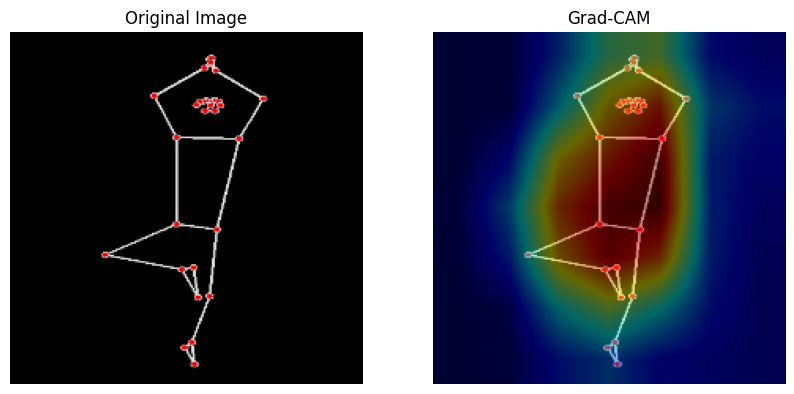

In [15]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Model

def get_gradcam_heatmap(model, img_array, layer_name):
    # Ensure the model is in inference mode
    model.trainable = False

    # Create a model that maps the input image to the activations of the last convolutional layer
    grad_model = Model(inputs=model.input, outputs=[model.output, model.get_layer(layer_name).output])

    # Compute the gradients of the top predicted class for the input image
    with tf.GradientTape() as tape:
        preds, conv_outputs = grad_model(np.array([img_array]))  # Add batch dimension
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # Get the gradients of the top predicted class with respect to the output feature map
    grads = tape.gradient(top_class_channel, conv_outputs)

    # Pool the gradients across the spatial dimensions
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    # Weight the output feature map by the pooled gradients
    conv_outputs = conv_outputs[0]  # Remove batch dimension
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # Apply ReLU to the heatmap to get the final heatmap
    heatmap = np.maximum(heatmap, 0)

    # Normalize the heatmap
    heatmap /= np.max(heatmap)

    return heatmap

def display_gradcam(img, heatmap, alpha=0.4):
    # Resize the heatmap to match the original image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Convert the heatmap to color
    heatmap = np.uint8(255 * heatmap)  # Scale to [0, 255]
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # Apply colormap

    # Superimpose the heatmap on the original image
    superimposed_img = cv2.addWeighted(heatmap, alpha, img, 1 - alpha, 0)

    return superimposed_img

# Load a sample image from the test set
img_path = test_generator.filepaths[0]  # Adjust index as needed
img = cv2.imread(img_path)
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize image
img_array = img / 255.0  # Normalize the image

# Specify the layer name for Xception
layer_name = 'block14_sepconv2_act'  # The last convolutional layer in Xception

# Generate Grad-CAM heatmap
heatmap = get_gradcam_heatmap(model, img_array, layer_name)

# Display the Grad-CAM heatmap on the image
superimposed_img = display_gradcam(img, heatmap)

# Show the original image and the Grad-CAM result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.title('Grad-CAM')
plt.axis('off')

plt.show()


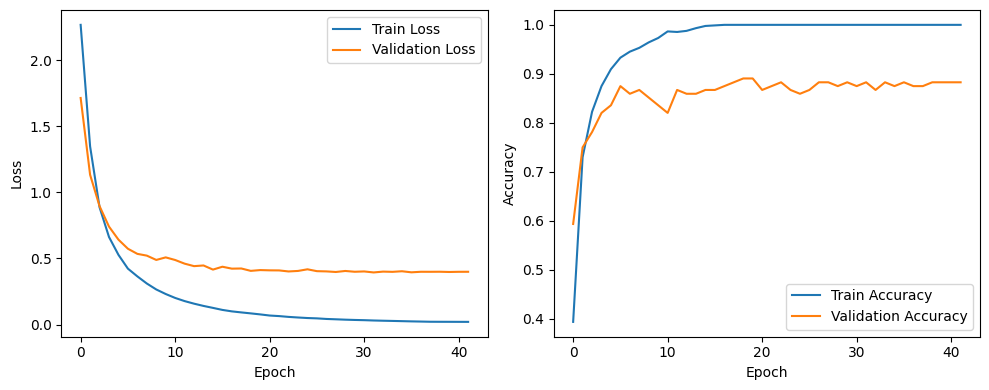

In [16]:
# Plot training & validation accuracy and loss
def plot_training_history(history):
    plt.figure(figsize=(10, 4))

    # Plot training & validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training & validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()
# After training the model
plot_training_history(history)

In [17]:
# Load the best model
model.load_weights('best_model.keras')

In [18]:
# Predict on the test set
test_generator.reset()
preds = model.predict(test_generator, steps=ceil(test_generator.samples / batch_size), verbose=1)
pred_labels = np.argmax(preds, axis=1)
true_labels = test_generator.classes

8/8 [==============================] - 3s 309ms/step


In [19]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Assuming true_labels and pred_labels are defined
class_names = [
    "Chair Pose",
    "Dolphin Plank Pose",
    "Downward Facing Dog Pose",
    "Fish Pose",
    "Goddess Pose",
    "Locust Pose",
    "Lord of the Dance Pose",
    "Low Lunge Pose",
    "Seated Forward Bend Pose",
    "Side Plank Pose",
    "Staff Pose",
    "Tree Pose",
    "Warrior 1 Pose",
    "Warrior 2 Pose",
    "Warrior 3 Pose",
    "Wide Angle Seated Forward Bend Pose"
]

# Print classification report
report = classification_report(true_labels, pred_labels, target_names=class_names, output_dict=True)

# Convert metrics to percentages
acc = accuracy_score(true_labels, pred_labels)
overall_accuracy = acc * 100

# Calculate overall precision, recall, and F1 score
overall_precision = precision_score(true_labels, pred_labels, average='weighted') * 100
overall_recall = recall_score(true_labels, pred_labels, average='weighted') * 100
overall_f1 = f1_score(true_labels, pred_labels, average='weighted') * 100

# Prepare data for DataFrame
data = {
    "Class": [],
    "Accuracy (%)": [],
    "Precision (%)": [],
    "Recall (%)": [],
    "F1-score (%)": []
}

# Populate data for each class
for class_name, metrics in report.items():
    if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
        per_class_accuracy = metrics['recall'] * 100  # Recall is equivalent to per-class accuracy
        data["Class"].append(class_name)
        data["Accuracy (%)"].append(f"{per_class_accuracy:.2f}")
        data["Precision (%)"].append(f"{metrics['precision'] * 100:.2f}")
        data["Recall (%)"].append(f"{metrics['recall'] * 100:.2f}")
        data["F1-score (%)"].append(f"{metrics['f1-score'] * 100:.2f}")

# Create a DataFrame
df_report = pd.DataFrame(data)

# Print overall accuracy and additional metrics
print(f"Overall Accuracy: {overall_accuracy:.2f}%")
print(f"Overall Precision: {overall_precision:.2f}%")
print(f"Overall Recall: {overall_recall:.2f}%")
print(f"Overall F1 Score: {overall_f1:.2f}%\n")

# Print the DataFrame
print(df_report.to_string(index=False))

Overall Accuracy: 93.36%
Overall Precision: 93.67%
Overall Recall: 93.36%
Overall F1 Score: 93.34%

                              Class Accuracy (%) Precision (%) Recall (%) F1-score (%)
                         Chair Pose        93.75         83.33      93.75        88.24
                 Dolphin Plank Pose        93.75         83.33      93.75        88.24
           Downward Facing Dog Pose       100.00        100.00     100.00       100.00
                          Fish Pose        75.00         80.00      75.00        77.42
                       Goddess Pose       100.00        100.00     100.00       100.00
                        Locust Pose        93.75         93.75      93.75        93.75
             Lord of the Dance Pose        93.75         93.75      93.75        93.75
                     Low Lunge Pose        81.25         92.86      81.25        86.67
           Seated Forward Bend Pose        93.75        100.00      93.75        96.77
                    Side Plank

[[15  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0 15  0  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 16  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0 12  0  0  0  0  0  0  0  0  0  0  2  1]
 [ 0  0  0  0 16  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0 15  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 15  0  0  0  0  0  0  0  1  0]
 [ 1  2  0  0  0  0  0 13  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0 15  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0  0 13  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 16  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 16  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0 15  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 16  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 16  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0  0  0 15]]


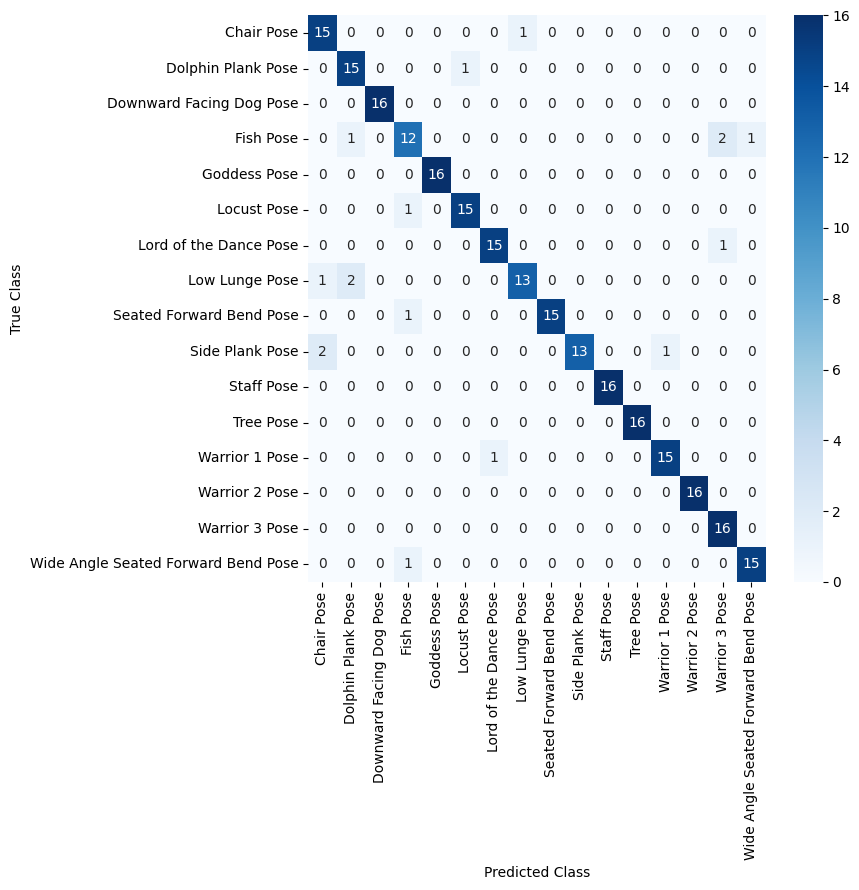

In [20]:
# Plot confusion matrix with class names
conf_matrix = confusion_matrix(true_labels, pred_labels)
print(conf_matrix)
plt.figure(figsize=(9, 9))

# Use class_names for x-ticks and y-ticks
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)

plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.xticks(rotation=90)  # Rotate x-tick labels for better readability
plt.yticks(rotation=0)   # Keep y-tick labels horizontal
plt.tight_layout()
plt.show()

In [21]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

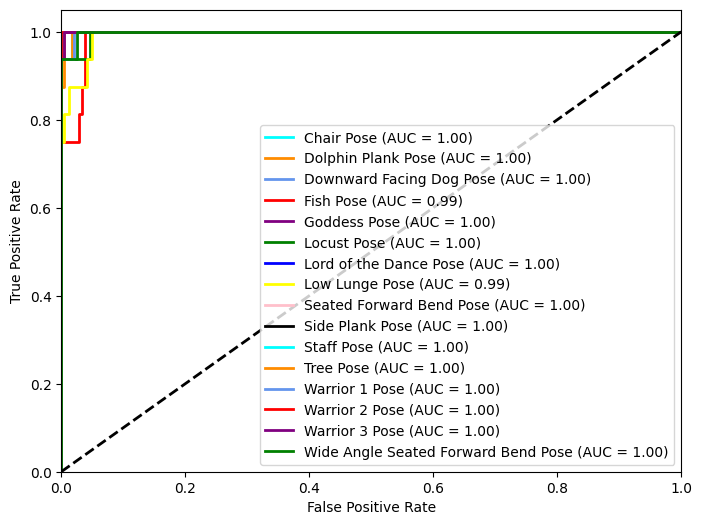

In [22]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle
import numpy as np

# Number of classes
n_classes = len(class_names)

# Binarize the true labels for multi-class ROC computation
y_test_bin = label_binarize(true_labels, classes=np.arange(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'purple', 'green', 'blue', 'yellow', 'pink', 'black'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='{} (AUC = {:.2f})'.format(class_names[i], roc_auc[i]))

# Plot diagonal line for reference
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Set plot limits and labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

# Show the plot
plt.show()